In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('leftfoot_freemocap_5min.csv')
df["datetime"] = pd.to_datetime(df["time"], format='ISO8601')
print(df.head())


        timestamp  com_right_foot_x  com_right_foot_y  com_right_foot_z  \
0  80984731656450       -131.819207        437.807048       1650.421200   
1  80984768285750       -131.436230        437.142920       1651.792637   
2  80984804356500       -131.161234        436.691145       1652.816794   
3  80984857611050       -131.213842        436.514692       1653.445923   
4  80984894285900       -131.297704        436.642029       1653.913199   

          t                         time        vx        vy        vz  \
0  0.000000         2025-12-04T15:41:06Z       NaN       NaN       NaN   
1  0.036629  2025-12-04T15:41:06.036629Z  0.010455 -0.018131  0.037441   
2  0.072700  2025-12-04T15:41:06.072700Z  0.007624 -0.012525  0.028393   
3  0.125955  2025-12-04T15:41:06.125955Z -0.000988 -0.003313  0.011814   
4  0.162629  2025-12-04T15:41:06.162629Z -0.002287  0.003472  0.012741   

         ax        ay        az   a_mag_g                         datetime  
0       NaN       NaN      

In [3]:

# RPE data with date + time
rpe_data = {
    "datetime": [
        "2025-12-04 15:41:00",
        "2025-12-04 15:42:00",
        "2025-12-04 15:43:00",
        "2025-12-04 15:44:00",
        "2025-12-04 15:45:00",
        "2025-12-04 15:46:00",
    ],
    "rpe": [2, 4, 6, 7, 9, 10]
}

rpe_df = pd.DataFrame(rpe_data)
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], format='ISO8601')
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], utc=True)


print(rpe_df)


                   datetime  rpe
0 2025-12-04 15:41:00+00:00    2
1 2025-12-04 15:42:00+00:00    4
2 2025-12-04 15:43:00+00:00    6
3 2025-12-04 15:44:00+00:00    7
4 2025-12-04 15:45:00+00:00    9
5 2025-12-04 15:46:00+00:00   10


In [4]:
df["minute"] = df["datetime"].dt.floor("min")
rpe_df["minute"] = rpe_df["datetime"].dt.floor("min")


In [5]:
acc_features = (
    df.groupby("minute")["a_mag_g"]
      .agg(
          mean_acc="mean",
          rms_acc=lambda x: (x**2).mean()**0.5,
          std_acc="std",
          p95_acc=lambda x: x.quantile(0.95)
      )
      .reset_index()
)
acc_features

,minute,mean_acc,rms_acc,std_acc,p95_acc
0,2025-12-04 15:41:00+00:00,1.663783,1.736613,0.497887,2.697524
1,2025-12-04 15:42:00+00:00,1.696730,1.774368,0.519359,2.725829
2,2025-12-04 15:43:00+00:00,1.686319,1.760063,0.504341,2.708492
3,2025-12-04 15:44:00+00:00,1.760279,1.833583,0.513513,2.736101
4,2025-12-04 15:45:00+00:00,1.748729,1.823219,0.516056,2.700274
5,2025-12-04 15:46:00+00:00,1.679464,1.755371,0.511384,2.688386


In [6]:
model_df = pd.merge(
    rpe_df,
    acc_features,
    on="minute",
    how="inner"
)
print(model_df)

                   datetime  rpe                    minute  mean_acc  \
0 2025-12-04 15:41:00+00:00    2 2025-12-04 15:41:00+00:00  1.663783   
1 2025-12-04 15:42:00+00:00    4 2025-12-04 15:42:00+00:00  1.696730   
2 2025-12-04 15:43:00+00:00    6 2025-12-04 15:43:00+00:00  1.686319   
3 2025-12-04 15:44:00+00:00    7 2025-12-04 15:44:00+00:00  1.760279   
4 2025-12-04 15:45:00+00:00    9 2025-12-04 15:45:00+00:00  1.748729   
5 2025-12-04 15:46:00+00:00   10 2025-12-04 15:46:00+00:00  1.679464   

    rms_acc   std_acc   p95_acc  
0  1.736613  0.497887  2.697524  
1  1.774368  0.519359  2.725829  
2  1.760063  0.504341  2.708492  
3  1.833583  0.513513  2.736101  
4  1.823219  0.516056  2.700274  
5  1.755371  0.511384  2.688386  


In [7]:
X = model_df[["rms_acc"]]
y = model_df["rpe"]


from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

loo = LeaveOneOut()

y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred.append(model.predict(X_test)[0])
    y_true.append(y_test.values[0])


In [8]:
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2:", r2_score(y_true, y_pred))


MAE: 3.07375594833813
R2: -0.6989476853305918


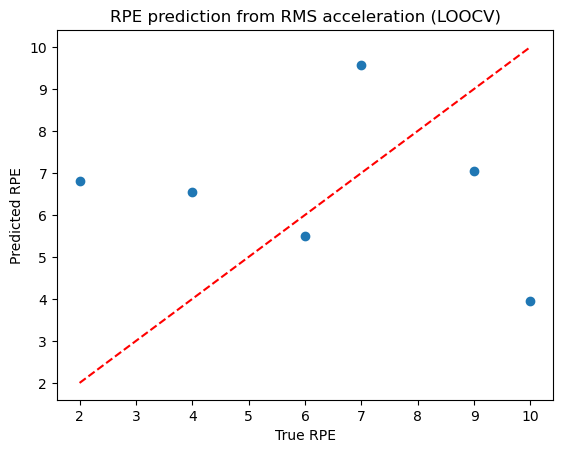

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], "r--")
plt.xlabel("True RPE")
plt.ylabel("Predicted RPE")
plt.title("RPE prediction from RMS acceleration (LOOCV)")
plt.show()


In [10]:
X = model_df[["rms_acc"]]
y = model_df["rpe"]

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

loo = LeaveOneOut()

y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=2,        
        min_samples_leaf=2, 
        random_state=0
    )

    rf.fit(X_train, y_train)
    y_pred.append(rf.predict(X_test)[0])
    y_true.append(y_test.values[0])

print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2:", r2_score(y_true, y_pred))


MAE: 2.810166666666666
R2: -0.581219497549019


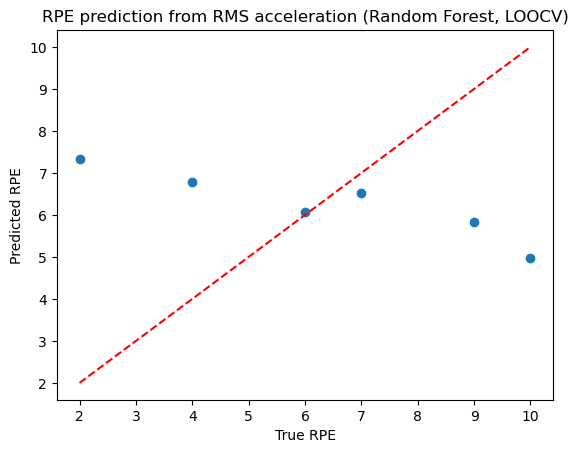

In [11]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], "r--")
plt.xlabel("True RPE")
plt.ylabel("Predicted RPE")
plt.title("RPE prediction from RMS acceleration (Random Forest, LOOCV)")
plt.show()


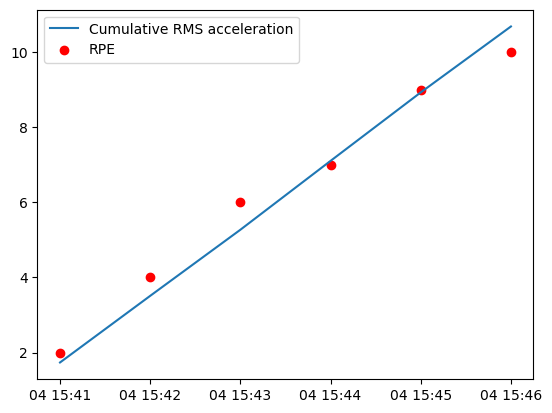

In [12]:
model_df["cum_rms"] = model_df["rms_acc"].cumsum()

import matplotlib.pyplot as plt

plt.plot(model_df["minute"], model_df["cum_rms"], label="Cumulative RMS acceleration")
plt.scatter(model_df["minute"], model_df["rpe"], color="red", label="RPE")
plt.legend()
plt.show()
